In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.io import fits
import pandas as pd
from IPython.display import set_matplotlib_formats

import HELP
gmod = HELP.get_model
makmod = HELP.make_spotmodel
Dotter_rad = HELP.Dotter_rad
MagConvert = HELP.MagConvert

import getMag
getMag = getMag.getMag

import getMag_hires
getMag_hires = getMag_hires.getMag_hires

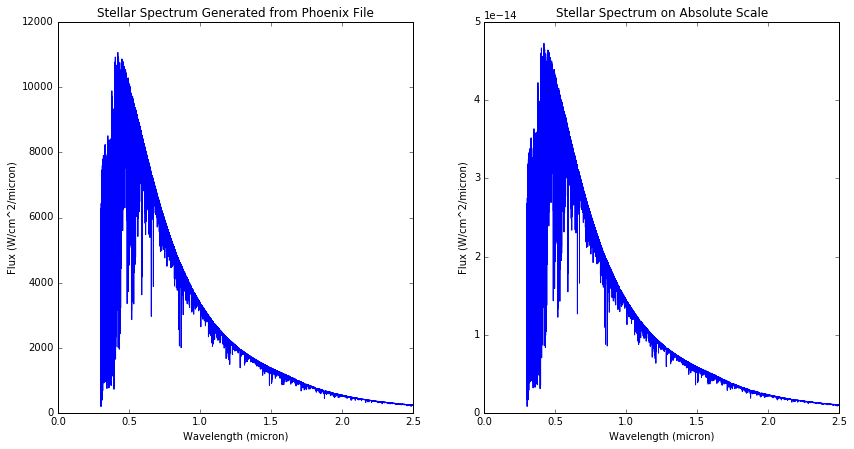

In [2]:
PhTemp = '5800'
SpTemp = '5800'
FillFactor = .2
wavelength,flux_Phoenix,PhTemp,SpTemp,FillFactor = makmod(PhTemp,SpTemp,FillFactor) #Creates spectrum for desired temps and fill-factor
Flux = Dotter_rad( PhTemp, flux_Phoenix )

plt.figure(figsize = (14,7))
plt.subplot(121)
plt.plot(wavelength,flux_Phoenix)
plt.title('Stellar Spectrum Generated from Phoenix File')
plt.xlabel('Wavelength (micron)')
plt.ylabel(r'Flux (W/cm^2/micron)')

plt.subplot(122)
plt.plot(wavelength,Flux)
plt.title('Stellar Spectrum on Absolute Scale')
plt.xlabel('Wavelength (micron)')
plt.ylabel(r'Flux (W/cm^2/micron)')

[('U', 0.365, 5.759067669770582), ('B', 0.445, 5.6207500916502084), ('V', 0.551, 4.9873442775360353), ('R', 0.658, 4.665521066171797), ('I', 0.806, 4.3644285195983379), ('J', 1.235, 3.8523143669529549), ('H', 1.662, 3.5336828281312349), ('Ks', 2.159, 3.4734758714095282), ('u', 0.356, 6.5404408410765154), ('g', 0.483, 5.2083699635717862), ('r', 0.626, 4.8238891349299191), ('i', 0.767, 4.7122876096853039), ('z', 0.91, 4.7081903321277174)]
[6.5490676697705821, 5.5307500916502086, 5.0073442775360348, 4.8755210661717969, 4.8144285195983381, 4.7623143669529551, 4.923682828131235, 5.3234758714095278, 7.4504408410765155, 5.1283699635717861, 4.663889134929919, 4.3422876096853038, 5.2481903321277175]


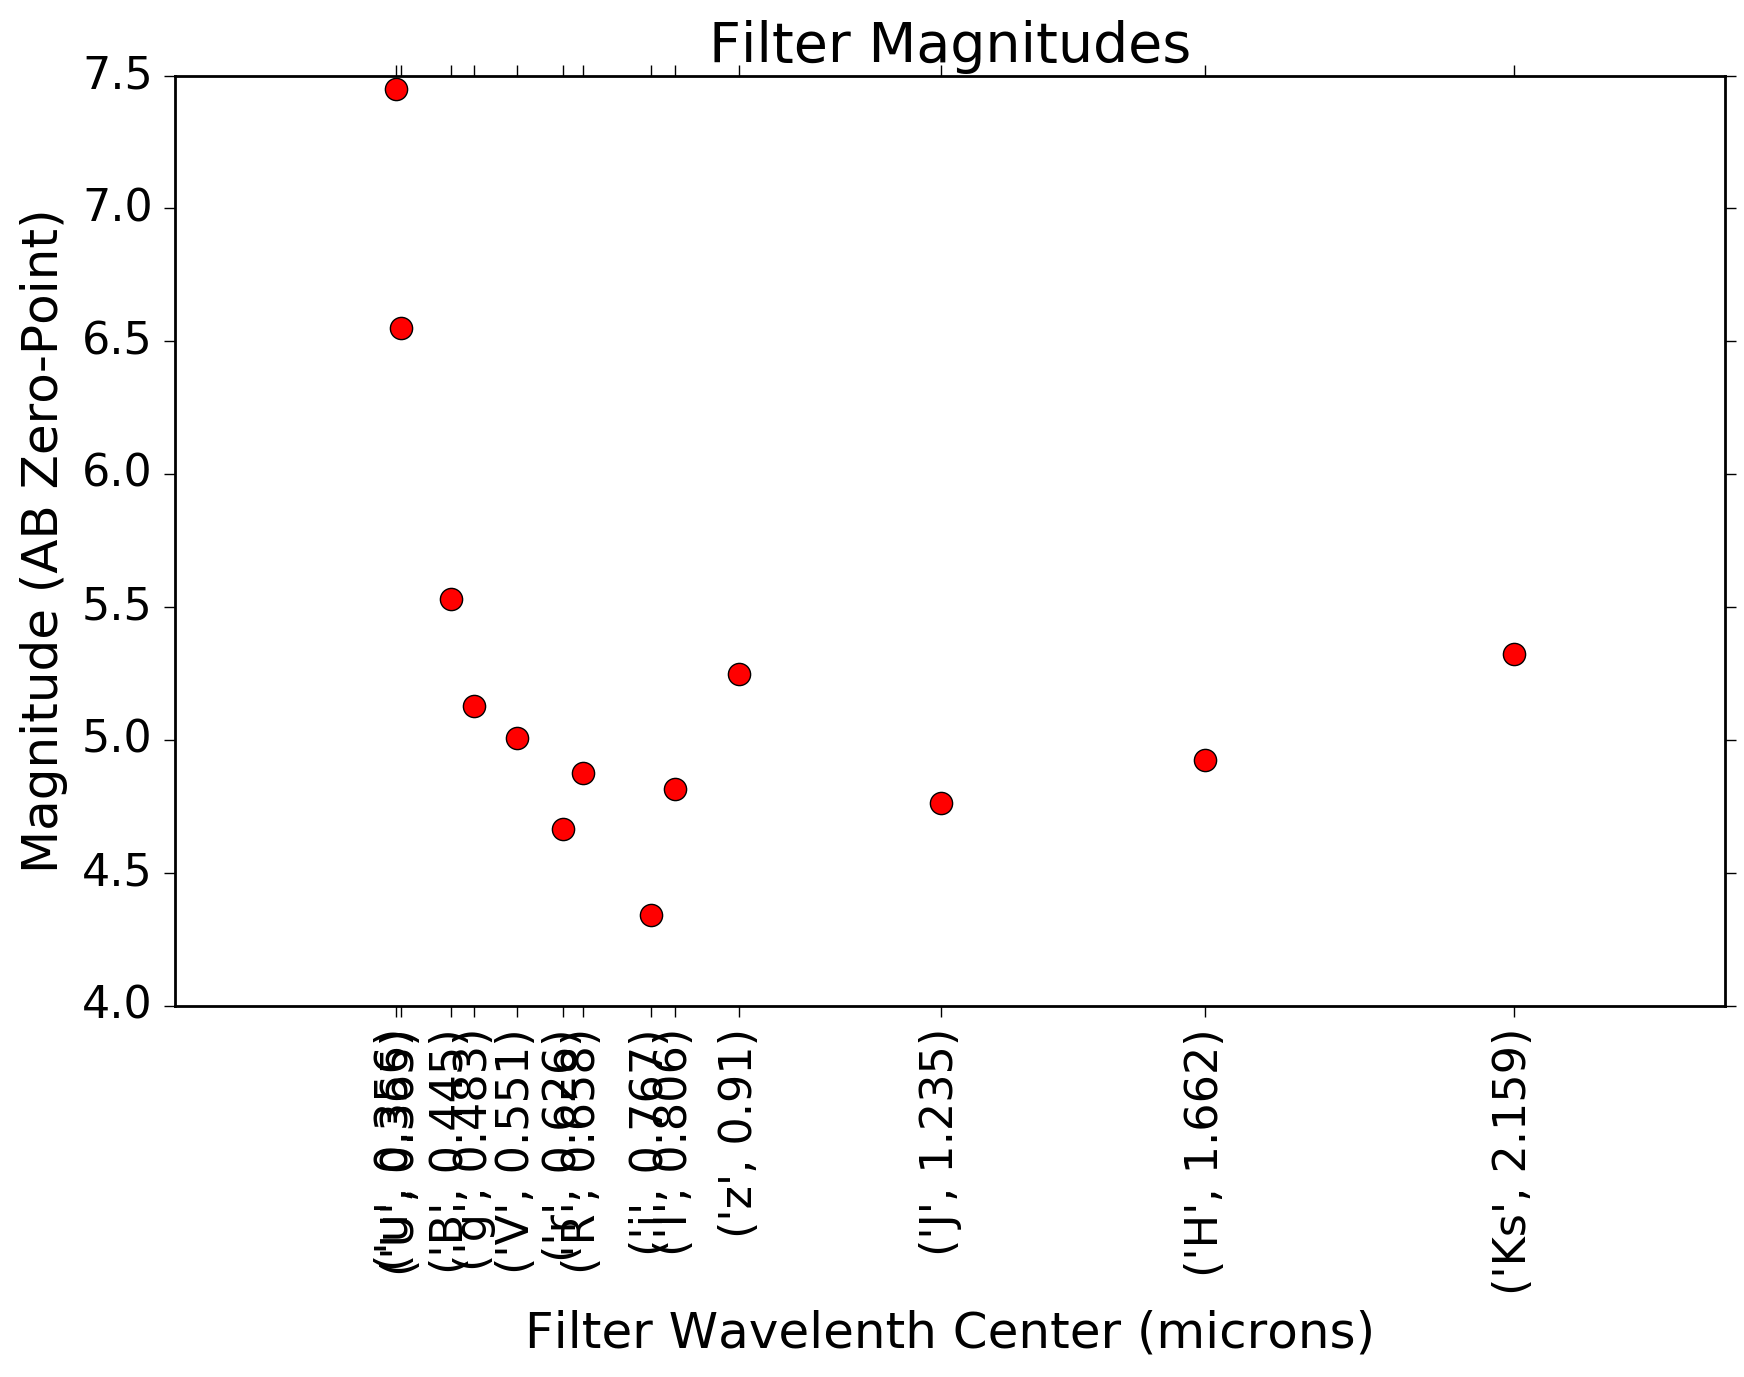

In [4]:
#initialize arrays of filter names
bands = np.array(['U','B','V','R','I','J','H','Ks','u','g','r','i','z'])
bands_hires = ['Ks','H','J']


#fill up a 3D array 'syn_phot' with: filter name, center point, magnitude
syn_phot = []
for i in range(len(bands)):
    x = getMag(bands[i],wavelength,Flux,'microns') #x returns three values; band, center, mag
    syn_phot.append(x)
    
#syn_phot_hires = []
#for i in range(len(bands_hires)):
#    y = getMag_hires(bands_hires[i],wavelength,tot_flux,'angstrom') #y returns three values; band, center, mag
#    syn_phot_hires.append(y)

#def getKey(item):
#    return item[1]
#syn_phot = sorted(syn_phot, key=getKey)

print(syn_phot)

Filters, Centers, Magnitudes = MagConvert(syn_phot)


print(Magnitudes)

#plt.figure(figsize=(10,10))
plt.tight_layout
plt.plot(Centers,Magnitudes,'ro')
plt.title('Filter Magnitudes')

xlab = list(zip(Filters,Centers)) #Could use some cleaning up

plt.xticks(Centers,xlab,rotation='vertical')
plt.xlabel('Filter Wavelenth Center (microns)')
plt.ylabel('Magnitude (AB Zero-Point)')

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rcParams['xtick.direction'] ='out'
mpl.rcParams['ytick.direction'] = 'out'
fig=plt.figure()
fig.savefig('Initial_Mags.png')

#centers_hires = [i[1] for i in syn_phot_hires]
#magnitudes_hires = [i[2] for i in syn_phot_hires]
#plt.plot(centers_hires,magnitudes_hires,'bo')